# Аналитика мобильного приложения
### Цель проекта:

Провести исследование причин появления убытков последние месяцы. Выявить причины неокупаемости рекламных компаний, в которые было вложено много средств.

У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. В ходе работы изучим, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

### Описание данных
Три датасета: файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о покупках, а costs_info_short.csv — информацию о расходах на рекламу.  

Структура visits_info_short.csv  
User Id — уникальный идентификатор пользователя,  
Region — страна пользователя,  
Device — тип устройства пользователя,  
Channel — идентификатор источника перехода,  
Session Start — дата и время начала сессии,  
Session End — дата и время окончания сессии.  

Структура orders_info_short.csv  
User Id — уникальный идентификатор пользователя,  
Event Dt — дата и время покупки,  
Revenue — сумма заказа.  
Структура costs_info_short.csv  

Channel — идентификатор рекламного источника,  
Dt — дата проведения рекламной кампании,  
Costs — расходы на эту кампанию.  

## Шаг 1. Загрузка данных и подготовка  к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

### Импорт нужных библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

try: #используем конструкцию try-except чтобы 100% прочитать файл
    visits_data = pd.read_csv('C:/Users/Полинария/Downloads/visits_info_short.csv', sep=',') #чтение локально
    orders_data = pd.read_csv('C:/Users/Полинария/Downloads/orders_info_short.csv', sep=',')
    costs_data = pd.read_csv('C:/Users/Полинария/Downloads/costs_info_short.csv', sep=',')
except:
    visits_data = pd.read_csv('/datasets/visits_info_short.csv', sep=',') #чтение файла на сервере
    orders_data = pd.read_csv('/datasets/orders_info_short.csv', sep=',')
    costs_data = pd.read_csv('/datasets/costs_info_short.csv', sep=',')
display(visits_data.head())#знакомимся с данными
display(orders_data.head())
display(costs_data.head())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


### Преобразование данных для анализа
Прежде всего переименуем названия столбцов и преобразуем данные о времени:

In [2]:
visits_data.rename(columns = {'User Id':'user_id', 'Region':'region', 'Device':'device', 'Channel':'channel', 'Session Start':'session_start', 'Session End':'session_end'}, inplace = True)
orders_data.rename(columns ={'User Id':'user_id', 'Event Dt':'event_dt','Revenue':'revenue'}, inplace = True)
costs_data.rename(columns ={'Channel':'channel'}, inplace = True)

display(visits_data.columns) #проверяем
display(orders_data.columns)
display(costs_data.columns)

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

Index(['dt', 'channel', 'costs'], dtype='object')

In [3]:
visits_data['session_start'] = pd.to_datetime(visits_data['session_start'])
visits_data['session_end'] = pd.to_datetime(visits_data['session_start'])
orders_data['event_dt'] = pd.to_datetime(orders_data['event_dt'])
costs_data['dt'] = pd.to_datetime(costs_data['dt']).dt.date

visits_data.info() #посмотрим что получилось с типами и общую информацию о таблицах
orders_data.info()
costs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

Проверка на пропуски и дубли:

In [4]:
round((visits_data.isna().mean()*100),2)

user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64

In [5]:
round((orders_data.isna().mean()*100),2)

user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64

In [6]:
round((costs_data.isna().mean()*100),2)

dt         0.0
channel    0.0
costs      0.0
dtype: float64

In [7]:
print('Дубликатов в логе с данными о посещениях выявлено:', visits_data.duplicated().sum())
print('Дубликатов в выгрузке с данными о покупках выявлено:', orders_data.duplicated().sum())
print('Дубликатов в таблице рекламных расходов выявлено:', costs_data.duplicated().sum())

Дубликатов в логе с данными о посещениях выявлено: 0
Дубликатов в выгрузке с данными о покупках выявлено: 0
Дубликатов в таблице рекламных расходов выявлено: 0


## Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии
Для дальнейшего анализа и расчетов зададим необходимые функции.  
### Функция для расчета удержания:

In [8]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета конверсии:

In [9]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета LTV и ROI:

In [10]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Выводы по Шагу 2:
Функции для проведения исследования определены.

## Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### Построение профилей пользователей

In [11]:
# находим параметры первых посещений
profiles = (
    visits_data.sort_values(by=['user_id', 'session_start'])
    .groupby('user_id')
    .agg(
        {
         'session_start': 'first',
         'channel': 'first',
         'device': 'first',
         'region': 'first',
            }
        )
    .rename(columns={'session_start': 'first_ts'})
    .reset_index()
)

# для когортного анализа определяем дату первого посещения
# и первый день месяца, в который это посещение произошло
profiles['dt'] = profiles['first_ts'].dt.date
profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

# добавляем признак платящих пользователей
profiles['payer'] = profiles['user_id'].isin(orders_data['user_id'].unique())

new_users = (
    profiles.groupby(['dt', 'channel'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'unique_users'})
    .reset_index()
)

# объединяем траты на рекламу и число привлечённых пользователей
costs_data = costs_data.merge(new_users, on=['dt', 'channel'], how='left')

# делим рекламные расходы на число привлечённых пользователей
costs_data['acquisition_cost'] = costs_data['costs'] / costs_data['unique_users']

# добавляем стоимость привлечения в профили
profiles = profiles.merge(
    costs_data[['dt', 'channel', 'acquisition_cost']],
    on=['dt', 'channel'],
    how='left',
)

# стоимость привлечения органических пользователей равна нулю
profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

display(profiles.sample(6))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
101736,678215556354,2019-07-14 17:21:38,FaceBoom,Android,United States,2019-07-14,2019-07-01,False,1.080473
56617,376158779892,2019-05-02 23:57:31,YRabbit,iPhone,United States,2019-05-02,2019-05-01,False,0.253846
97297,648253404661,2019-08-08 03:20:01,FaceBoom,PC,United States,2019-08-08,2019-08-01,False,1.115385
111823,744802707152,2019-07-19 09:44:43,WahooNetBanner,PC,UK,2019-07-19,2019-07-01,False,0.600000
4500,29971694333,2019-09-26 15:05:00,organic,PC,UK,2019-09-26,2019-09-01,False,0.000000
6519,43381692185,2019-05-26 15:54:33,organic,Mac,United States,2019-05-26,2019-05-01,False,0.000000


Кажется все получилось, теперь определим максимальную и минимальную даты привлечения пользователей:

In [12]:
display('Максимальная дата привлечения', profiles['first_ts'].max())
display('Минимальная дата привлечения', profiles['first_ts'].min())

'Максимальная дата привлечения'

Timestamp('2019-10-27 23:59:04')

'Минимальная дата привлечения'

Timestamp('2019-05-01 00:00:41')

Максимальная и минимальные даты привлечения соответсуют ожиданиям: из условия мы знали что у нас выгружены данные как раз за этот период.

### Распределение пользователей по регионам. Самые платежеспособные регионы.
Посмотрим какая доля пользователей приходится на какой регион. Для этого сделаем группировку по региону и посчитаем количество пользователей:

,user_id
region,
France,17450
Germany,14981
UK,17575
United States,100002


Text(0.5, 1.0, 'Распределение пользователей по регионам')

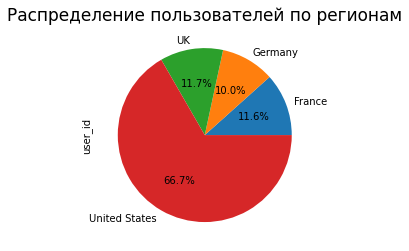

In [13]:
region_info = profiles.groupby(['region']).agg({'user_id': 'count'})
display(region_info)
region_info.plot(kind = 'pie',autopct='%1.1f%%', legend = False, subplots = True)
plt.title('Распределение пользователей по регионам', fontsize=17)



Более половины всех пользователей из США. Теперь посмотрим какие страны дают более всего платящих пользователей. Вообще скорее всего пользователей из США значительно больше, а значит и платящих будет больше, поэтому сотавим таблицу, где будут как и абсолютные значения, так и относительные (то есть какая доля пользователей из какого региона платит):

,user_id,paying_users,share_paying
region,,,
France,17450,663,0.037994
Germany,14981,616,0.041119
UK,17575,700,0.039829
United States,100002,6902,0.069019


Text(0.5, 1.0, 'Распределение платящих пользователей по регионам')

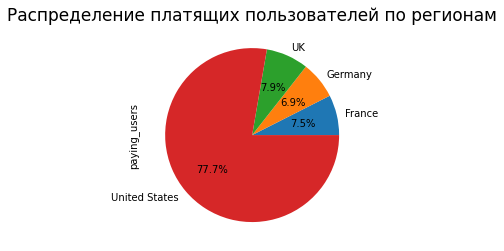

In [14]:
region_info['paying_users'] = profiles.query('payer == True').groupby(['region']).agg({'payer': 'count'})
region_info['share_paying'] = region_info['paying_users'] / region_info['user_id'] 
display(region_info)
region_info['paying_users'].plot(kind = 'pie',autopct='%1.1f%%', legend = False, subplots = True)
plt.title('Распределение платящих пользователей по регионам', fontsize=17)


Неутешительно, что менее 5% пользователей платят, а откуда деньги зарабатывать? Самая большая доля платящих в США - почти 7%, они же составляют 77% всех платящих пользователей, на втором месте (на удивление) - немцы.  


### Распределение по типам устройств. Наиболее популярные устройства платящих пользователей.
Посмотрим какими с каких устрйоств люди регистрируются в нашем приложении, опять таки посмотрим доли, выясним что популярнее:

,user_id
device,
Android,35032
Mac,30042
PC,30455
iPhone,54479


Text(0.5, 1.0, 'Распределение пользователей по устройствам')

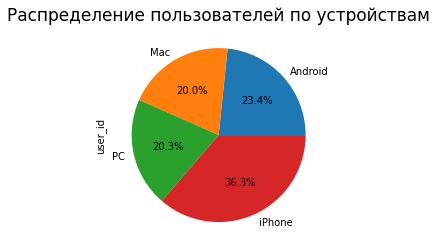

In [15]:
device_info = profiles.groupby(['device']).agg({'user_id': 'count'})
display(device_info)
device_info.plot(kind = 'pie',autopct='%1.1f%%', legend = False, subplots = True)
plt.title('Распределение пользователей по устройствам', fontsize=17)

Я думала будет большой перекос в сторону мобильных устройств, однако владельцы Mac и PC не сильно отстают, в лидер конечно же iPhone, предсказуемо. Но измениться что нибудь если мы посмотрим только платящих пользователей? Сотавим таблицу аналогичную распределению по регионам:

,user_id,paying_users,share_paying
device,,,
Android,35032,2050,0.058518
Mac,30042,1912,0.063644
PC,30455,1537,0.050468
iPhone,54479,3382,0.062079


array([<AxesSubplot:ylabel='paying_users'>], dtype=object)

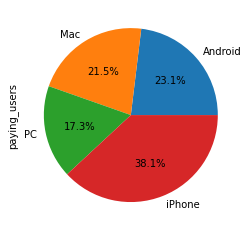

In [16]:
device_info['paying_users'] = profiles.query('payer == True').groupby(['device']).agg({'payer': 'count'})
device_info['share_paying'] = device_info['paying_users'] / device_info['user_id'] 
display(device_info)
device_info['paying_users'].plot(kind = 'pie',autopct='%1.1f%%', legend = False, subplots = True)

Опять косяк с визуализацией - мне некрасиво, но главное что поставленная задача выполнена и мы можем посмотреть какую долю платящих сотавляют пользователи разных устройств.  

Соотношение примерно такое же, как и в целом по пользователям, значит можно сделать вывод что дело не в оптимизации приложения под разные системы (ну а что у ПК всего 17% лишь напоминание о том, что владельцы ПК не очень любят платить деньги, да-да я тоже). В остальном можно заметить что относительно всех пользователей в разрезе по устройствам платящие составляют примерно 5-6%, немного лидируют пользователи техники Apple, но это выглядит как нормальная ситуация.  
### Распределение рекламных каналов. Самые оправданные каналы привлечения.
Ну и глянем откуда наши пользователи узнали о нашем приложении:

,user_id
channel,
AdNonSense,3880
FaceBoom,29144
LeapBob,8553
MediaTornado,4364
OppleCreativeMedia,8605
RocketSuperAds,4448
TipTop,19561
WahooNetBanner,8553
YRabbit,4312


Text(0.5, 1.0, 'Распределение по каналам привлечения')

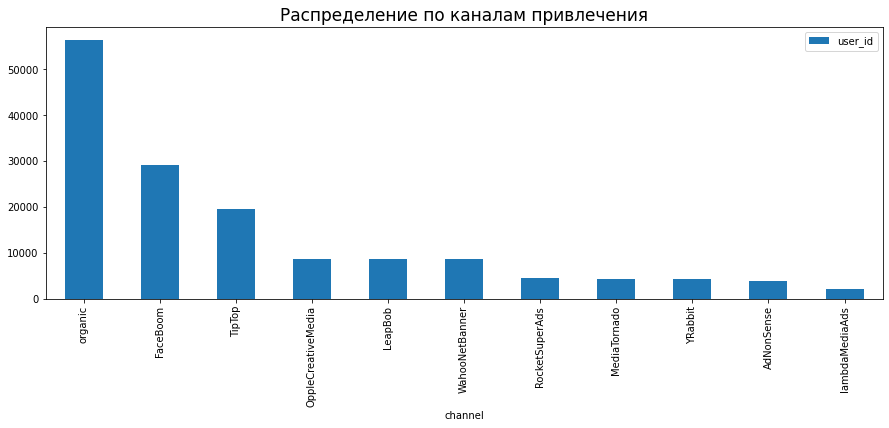

In [17]:
channel_info = profiles.groupby(['channel']).agg({'user_id': 'count'})
display(channel_info)
channel_info.sort_values(by = 'user_id', ascending=False).plot(kind = 'bar', figsize=(15,5))
plt.title('Распределение по каналам привлечения', fontsize=17)


Больше всего пользователей пришли "естесственным" путем. А вообще есть смысл тартиться на рекламу? :) Шучу конечно, это нам  и предстоит проверить:сравним с каких каналов пользователи чаще платят: составим таблицу + поппробуем сделать понятную визуализацию:

In [18]:
channel_info['paying_users'] = profiles.query('payer == True').groupby(['channel']).agg({'user_id': 'count'})
channel_info['share_paying'] =channel_info ['paying_users'] / channel_info ['user_id']
display(channel_info.sort_values(by = 'share_paying', ascending = False)) 

,user_id,paying_users,share_paying
channel,,,
FaceBoom,29144,3557,0.122049
AdNonSense,3880,440,0.113402
lambdaMediaAds,2149,225,0.104700
TipTop,19561,1878,0.096007
RocketSuperAds,4448,352,0.079137
WahooNetBanner,8553,453,0.052964
YRabbit,4312,165,0.038265
MediaTornado,4364,156,0.035747
LeapBob,8553,262,0.030633


Теперь очевидно, что пользователи, которые достались нам бесплатно - не самые платящие ребята. Всего 2% из них стали покупателями. С другой стороны они составляют 13% от всех платящих пользователей и достались нам бесплатно.

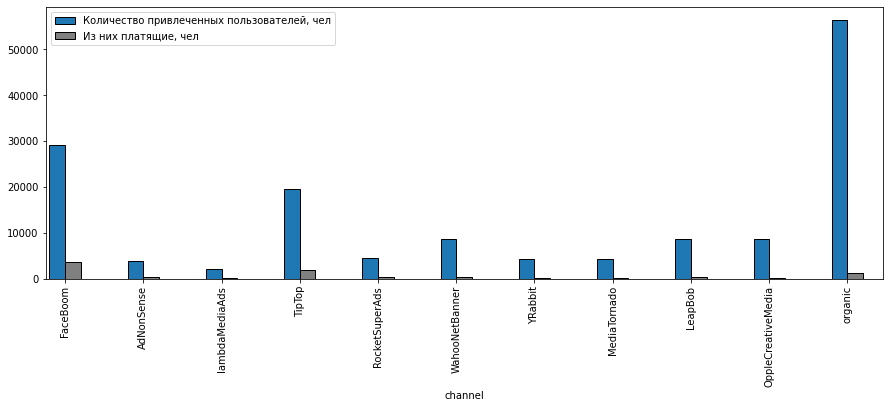

In [19]:
ax =  plt.gca()
channel_info = channel_info.sort_values(by = 'share_paying', ascending = False)
channel_info['user_id'].plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, position=1)
channel_info['paying_users'].plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, color='grey', position=0)

ax.legend(['Количество привлеченных пользователей, чел', 'Из них платящие, чел'])

Было бы здорово подписать на графике какую долю составляют платящие пользователи от всех платящих пользователей, а так же подписать какую долю составляют платящие от привлеченных в рамках канала привлечения, но я не нашла соответсвующий аргумент или функцию, которая позволила бы это реализовать. Сортировка на графике идет относительно того, какой процент от привлеченных пользователей в рамках канала платит - так лидер FaceBoom - 12% от привлеченных пользователей по этому каналу конвертировались в платящих. 

### Выводы по Шагу 3:
Пока рано делать какие либо заявления, однако точно можно сказать, что тип устройства не особо влияет на желание сделать покупку в приложении, а значит и ошибок оптимизации с перекосом в какое то устройство нет. Наши наилучшие покупатели - из США, они и чаще скачивают приложение и чаще совершают в нем покупки (тут я бы посоветовала сделать анализ включающий себя соответсвие функций приложения и менталитету). А что касается рекламных каналов надо проводить исследование дальше и оценить окупают ли пользователи затраты, потраченные на рекламу (спойлер:нет, так из из условия мы знаем что компания терпит убытки поэтому надо определить есть ли хоть один рекламный канал который окупается? а вдруг вообще вся реклама крайне неудачная и надо искать другие каналы привлечения, где аудитория будет более заинтресчованная или более платежеспособная?).  
Но главное, что мы составили профили пользователей, что в дальнейшем позволит нам ответить на поставленные вопросы.
## Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Думаю для ответов на данные вопросы мы продолжим работать с таблицей channel_info и costs_data:

In [20]:
channel_info = channel_info.merge(costs_data.groupby(['channel']).agg({'costs':'sum'}), on='channel') #добавили столбец с общей стоимостью затрат на рекламу в разрезе по каналам 
channel_info['expenses_per_user'] = channel_info['costs'] / channel_info['user_id'] #стоимость привлечения 1 пользователя
channel_info['expenses_per_paying_user'] = channel_info['costs'] / channel_info['paying_users'] #стоимость привлечния 1 покупателя
display(channel_info)

,user_id,paying_users,share_paying,costs,expenses_per_user,expenses_per_paying_user
channel,,,,,,
FaceBoom,29144,3557,0.122049,32445.60,1.113286,9.121619
AdNonSense,3880,440,0.113402,3911.25,1.008054,8.889205
lambdaMediaAds,2149,225,0.104700,1557.60,0.724802,6.922667
TipTop,19561,1878,0.096007,54751.30,2.799003,29.154047
RocketSuperAds,4448,352,0.079137,1833.00,0.412095,5.207386
WahooNetBanner,8553,453,0.052964,5151.00,0.602245,11.370861
YRabbit,4312,165,0.038265,944.22,0.218975,5.722545
MediaTornado,4364,156,0.035747,954.48,0.218717,6.118462
LeapBob,8553,262,0.030633,1797.60,0.210172,6.861069


Теперь мы знаем расходы на каналы. Есть идея попробовать посмотреть в рамках каждого канала средний чек платящих пользователей. Чтобы мы знали не только сколько в среднем тартим на 1 покупателя, но и средний чек платящего пользователя из каждого канала привлечения.

In [21]:
print('Расходы на маркетинг составили', channel_info['costs'].sum())

Расходы на маркетинг составили 105497.30000000003


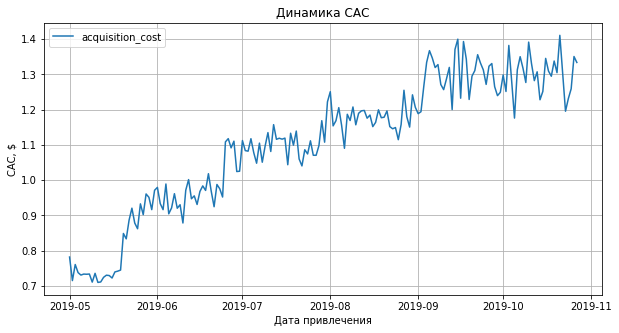

In [22]:
profiles = profiles.query('channel != "organic"')
profiles.pivot_table(
    index='dt', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС')
plt.show()

In [23]:
temp = orders_data.merge(visits_data, on = 'user_id') #временная таблица для группировки покупок по каналам - грубо говоря канал принес столько денег, на какую общую сумму совершили покупки пользователи привлеченные по этому каналу
channel_info = channel_info.merge(temp.groupby(['channel']).agg({'revenue':'sum'}), on = 'channel') #добавляем столбец с общей "прибилью канала"
channel_info['revenue_per_paying_user'] = channel_info['revenue'] / channel_info['paying_users'] #смотрим средний чек канала
display(channel_info)

,user_id,paying_users,share_paying,costs,expenses_per_user,expenses_per_paying_user,revenue,revenue_per_paying_user
channel,,,,,,,,
FaceBoom,29144,3557,0.122049,32445.60,1.113286,9.121619,6.543472e+04,18.396042
AdNonSense,3880,440,0.113402,3911.25,1.008054,8.889205,1.649379e+04,37.485886
lambdaMediaAds,2149,225,0.104700,1557.60,0.724802,6.922667,1.527807e+05,679.025200
TipTop,19561,1878,0.096007,54751.30,2.799003,29.154047,1.121218e+06,597.027625
RocketSuperAds,4448,352,0.079137,1833.00,0.412095,5.207386,2.362996e+05,671.305625
WahooNetBanner,8553,453,0.052964,5151.00,0.602245,11.370861,3.714667e+05,820.014857
YRabbit,4312,165,0.038265,944.22,0.218975,5.722545,1.114128e+05,675.229091
MediaTornado,4364,156,0.035747,954.48,0.218717,6.118462,1.005332e+05,644.443333
LeapBob,8553,262,0.030633,1797.60,0.210172,6.861069,1.489830e+05,568.637366


Теперь мы видим на одной таблице и среднюю стоимость привлеяения пользователя за рассматриваемый период и общие расходы на рекламу за рассматриваемый период и средний чек, но чтобы разбираться дальше посчитаем САС и построим график динамики САС в разрезе по каналам привлечения:

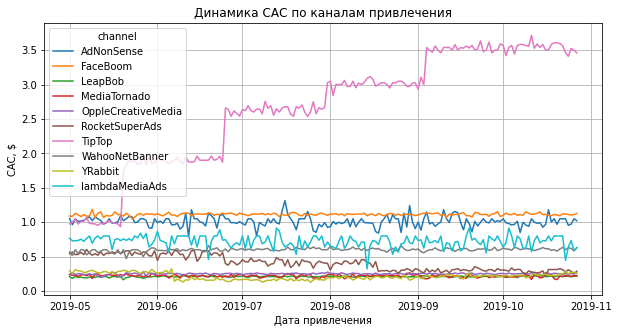

In [24]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Ну из того что сразу бросается в глаза - нестабильный САС по каналу TipTop! но чтобы график был нагляднее сгладим его - это раз, два - по мимо общего графика по всем каналам построим графики по каждому каналу в отдельности.

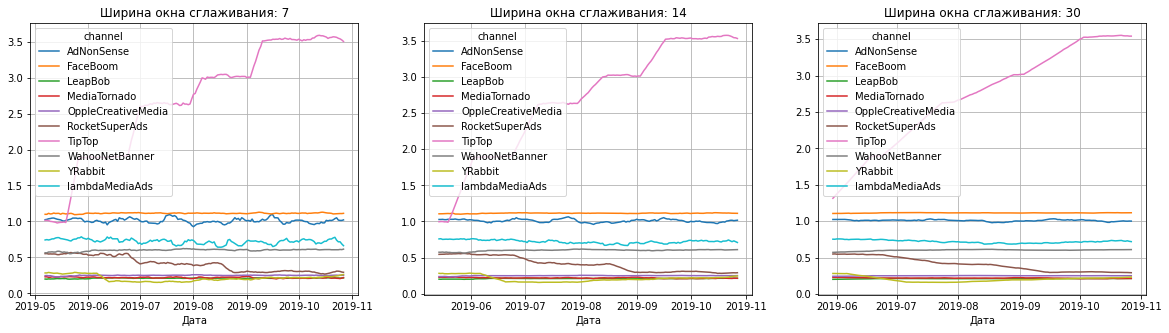

In [25]:
report = profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean')
plt.figure(figsize=(20, 5))

# перебираем размеры окон для скользящего среднего
for plot_num, window in enumerate([7, 14, 30]):
    # копируем исходный фрейм
    filtered_data = report.copy()
    # для каждого источника считаем скользящее среднее
    for column in report.columns.values:
        filtered_data[column] = filtered_data[column].rolling(window).mean()
    # строим график
    filtered_data.plot(grid=True, ax=plt.subplot(1, 3, plot_num + 1))
    plt.title('Ширина окна сглаживания: {}'.format(window))
    plt.xlabel('Дата')
plt.show()


Понятное дело, что чем шире окно, тем менее шумный график, но думаю стоит взять окно размером 14 дней. Напишем функуию для сглаживания и псотроим график САС по каналам:

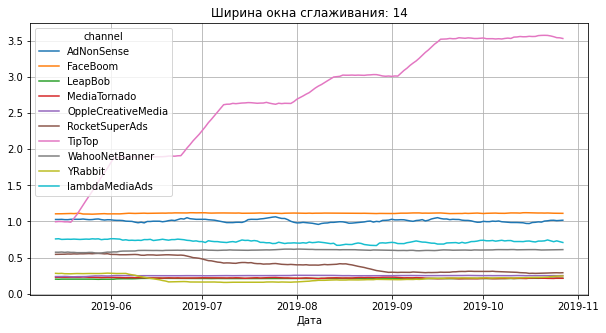

In [26]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

window = 14
filter_data(report, window).plot(figsize=(10, 5), grid = True)
plt.title('Ширина окна сглаживания: {}'.format(window))
plt.xlabel('Дата')
plt.show()

Можно сделать вывод, что САС по всем каналам привлечения кроме TipTop относительно стабилен (поэтому все таки не будем строить САС каждого канала), а вот рост САС у канала TipTop пугает! К слову САС всех каналов, кроме вышеупомятого соответвует затратам на привлоечение 1 пользователя, которые мы определили в таблице. Значит нигде не ошиблись)  

Тут вопрос: как вынести легенду графика за пределы сетки графика?

In [27]:
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)
display(cac)
print('средний САС всего проекта:', profiles['acquisition_cost'].mean())

,cac
channel,
AdNonSense,1.008054
FaceBoom,1.113286
LeapBob,0.210172
MediaTornado,0.218717
OppleCreativeMedia,0.250000
RocketSuperAds,0.412095
TipTop,2.799003
WahooNetBanner,0.602245
YRabbit,0.218975


средний САС всего проекта: 1.1274813239427588


### Выводы по Шагу 4:

Стоит обратить внимание на затраты на рекламу по каналу TipTop. САС не стабилен, а именно быстро растет вверх, возможно убытки последние месяцы связанны имеено с перерасходом на рекламную компанию в TipTop? 

## Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы 
Для анализа общей окупаемости рекламы посчитаеам и визуализируем LTV и ROI, вызвав функции, которые мы определили на Шаге 2. Но перед этим установим момент и горизонт анализа: 
по условию мы смотрим данные 1 ноября 2019 года - это и будет моментом. Так как окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей, то задаим горизонт анализа равный 14 дням:

In [28]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

Посчитаем LTV и ROI:

In [29]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders_data, observation_date, horizon_days
)
display(ltv_grouped,  roi_grouped)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.34558,0.435754,0.504507,0.56109,0.611436,0.654368,0.69414,0.729778,0.764619,0.796665,0.826152,0.85207,0.878116,0.90203


,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,,
All users,88644,1.117794,0.309163,0.389834,0.451341,0.501962,0.547002,0.58541,0.620991,0.652873,0.684043,0.712711,0.739091,0.762278,0.785579,0.806974


И сразу построим графики:

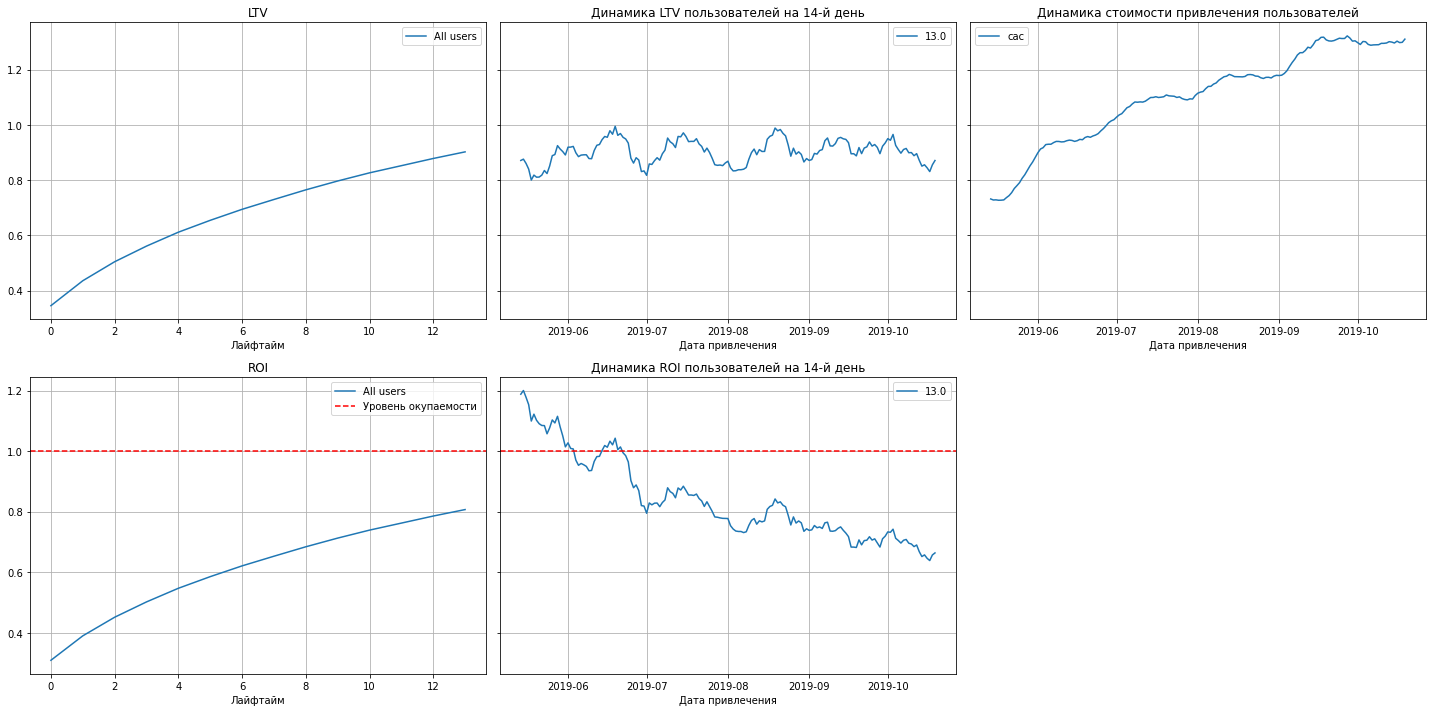

In [30]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):    
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Из графиков можно сделать следующие выводы: ну начнем с того, что плавно растущий LTV наталкивает на мысль, что при расчетах мы не допустили ошибок. 
Главный вывод - реклама не окупается: ROI к концу двухнедельного периода не достигает 1цы (0,98).  
САС колбасит и, как мы уже предполагали скорее всего это связано с махинациями в бюджетах на рекламу в TipTop. Уж больно график напоминает график САС TipTop.  
Динамика LTV не выглядит подозрительно, более того из динамики LTV следует, что нельзя говорить об ухудшении качества пользователей (что опять подтверждает нашу теорию с проблемами с бюджетом на рекламу), кроме того думаю пики в Динамике LTV связаны например с выходом обновлений/дополнений приложения.
Ну и ROI показывает, что действительно, как и было сказано в условии мы наблюдаем картину того, что компания терпит убытки послдение месяцы. 
Несмотря на то, что у нас есть гипотеза о причинах, чтобы точно разобраться продйем по всем доступным харпактеристикам пользователей - устройствам, странам и на десерт оставим рекламные компании.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам
Зададим дополнительную характеристику:

In [31]:
dimensions = ['device']

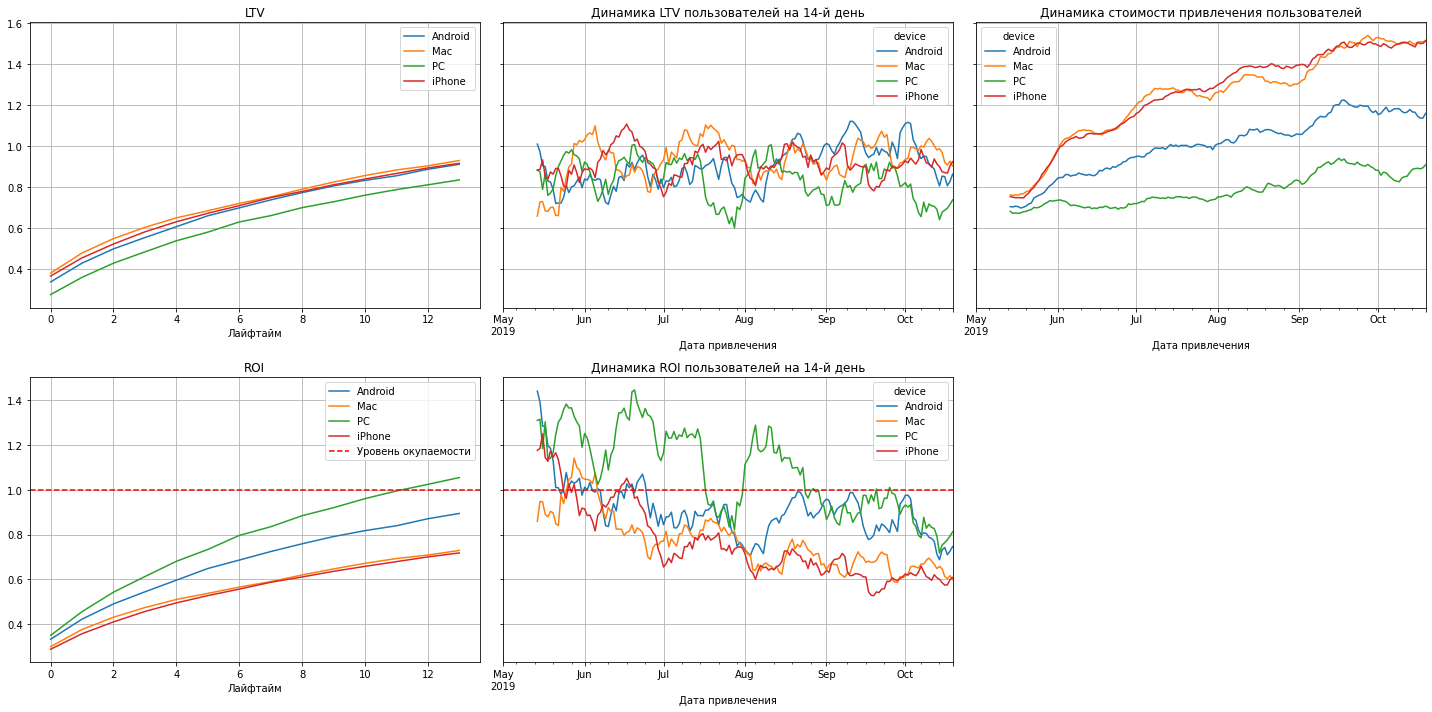

In [32]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders_data, observation_date, horizon_days, dimensions=dimensions
) #считаем

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) #рисуем

Динамика LTV и ROI по каждому устройству похожа на общую динамику. По всем устройствам наблюдается нестабильный, растущий САС, пусть и очевидно, что у пользователей яблочных устройств САС растет стремительней. Несмотря на то, что LTV  пользователей ПК наименьшее, но и стоимость их привлечения самая скромная, что позволяет выйти на окупаемость к началу второй недели. Пользователи Андроид также выходят на окупаемость, а их привлечение обходится дешевле. Главное, что можно понять, что дело не в пользователях конкретных устройств, идем дальше.

### Проанализируйте окупаемость рекламы с разбивкой по странам
Снова зададим признак, посчитаем, нарисуем:

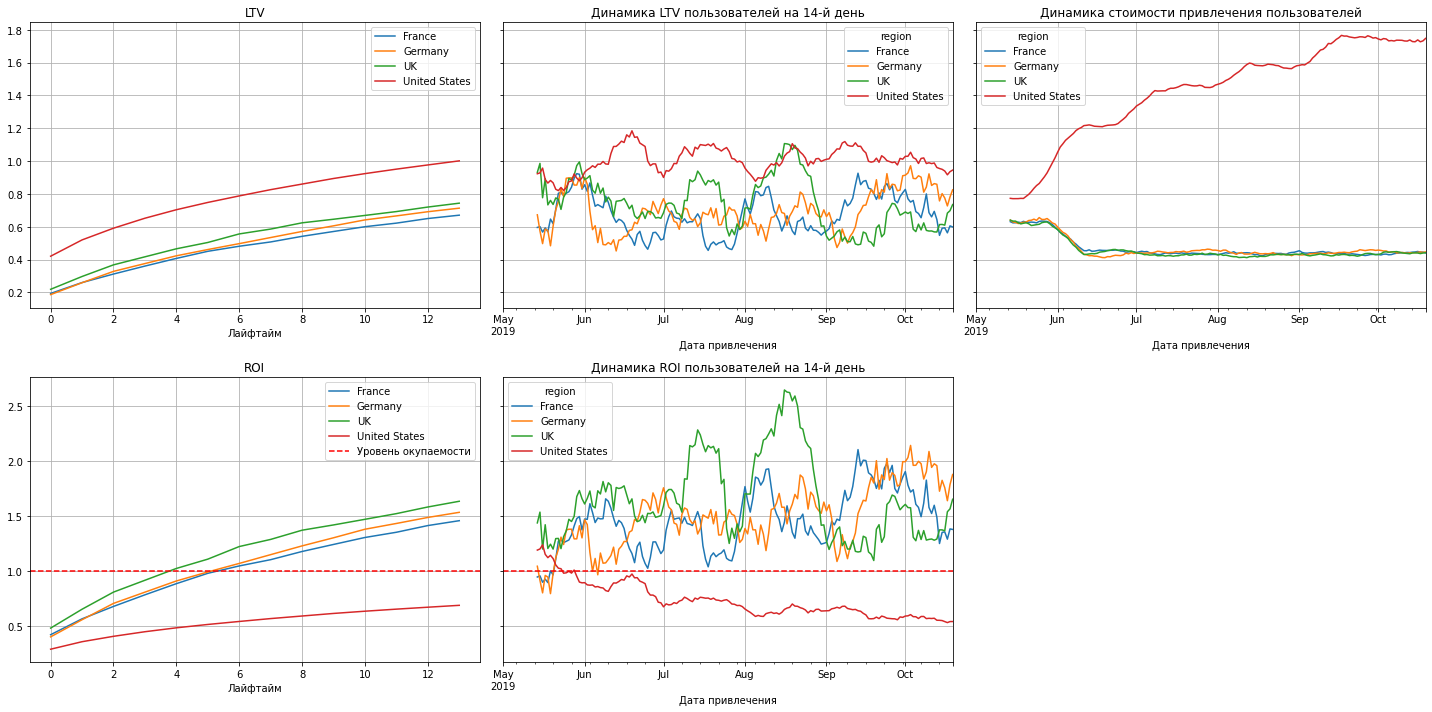

In [33]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders_data, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Вот тут уже интересно!Несмотря на то, что ценность пользователей из США выше, чем из других стран - они единственные не окупаются, в то время как привлечение пользователей из Европы окупается уже на третий день! Причем исходя из графиков динамики ROI и CAC видно, что в Июне САС американцев пошел резко в верх, потом немного упал и дальше попозл вверх, все это с небольшим лагом видно как отразилось на ROI пользователей из США. Кажется разгадка близка. И хоть по-моему уже очевидно, что копать надо под рекламные каналы, все равно посмотрим, что твориться с конверсией и удержанием пользователей из США. Посчитаем конверсию, вызвав функцию get_convertion:

In [34]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders_data, observation_date, horizon_days, dimensions=dimensions
)
display(conversion_grouped)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,
France,10516,0.033092,0.037467,0.040985,0.042697,0.044313,0.045359,0.046120,0.046405,0.046976,0.047547,0.047642,0.048117,0.048307,0.048402
Germany,9030,0.032337,0.038760,0.041528,0.043854,0.045072,0.046512,0.047398,0.048283,0.049059,0.049612,0.049723,0.049834,0.049945,0.050498
UK,10536,0.034074,0.039104,0.042426,0.044039,0.045368,0.046412,0.047551,0.048121,0.048405,0.048595,0.048975,0.049070,0.049165,0.049165
United States,58562,0.071873,0.080650,0.084560,0.087497,0.089700,0.091032,0.092022,0.093013,0.093798,0.094566,0.095096,0.095454,0.095728,0.096069


Судя по всему конверсия у пользователей из США стабильно выше, чем у пользователей из Европы. Может есть какой подвох в удержании? воспользуемся готовой функцией для расчета удержания из шага 2:

In [35]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits_data, observation_date, horizon_days, dimensions=dimensions
)
display(retention_grouped)

cohort_size    0         1         2         3         4  \
payer region                                                                    
False France                9993  1.0  0.173021  0.091164  0.052036  0.033724   
      Germany               8563  1.0  0.176690  0.084900  0.056172  0.035034   
      UK                   10002  1.0  0.179064  0.088582  0.051390  0.031994   
      United States        52776  1.0  0.177221  0.085626  0.051160  0.033500   
True  France                 523  1.0  0.474187  0.386233  0.323136  0.307839   
      Germany                467  1.0  0.483940  0.402570  0.314775  0.327623   
      UK                     534  1.0  0.483146  0.421348  0.327715  0.299625   
      United States         5786  1.0  0.354822  0.263913  0.212755  0.183719   

                            5         6         7         8         9  \
payer region                                                            
False France         0.022616  0.018213  0.014610  0.012108  0.010607   
      Germany        0.025225  0.019503  0.014014  0.010510  0.009926   
      UK             0.024595  0.017696  0.015897  0.011598  0.008498   
      United States  0.025030  0.018777  0.013813  0.011880  0.009474   
True  France         0.296367  0.246654  0.239006  0.223709  0.204589   
      Germany        0.284797  0.244111  0.220557  0.239829  0.211991   
      UK             0.277154  0.271536  0.247191  0.198502  0.155431   
      United States  0.166263  0.143623  0.136018  0.125475  0.122364   

                           10        11        12        13  
payer region                                                 
False France         0.007805  0.006304  0.005304  0.005504  
      Germany        0.007007  0.005722  0.006890  0.006540  
      UK             0.007299  0.006899  0.006399  0.004499  
      United States  0.007541  0.006423  0.005931  0.004301  
True  France         0.210325  0.168260  0.189293  0.173996  
      Germany        0.233405  0.173448  0.160600  0.134904  
      UK             0.168539  0.192884  0.183521  0.177903  
      United States  0.117179  0.106982  0.103007  0.089526

Для удержания все таки построим графики и наглядно посмотрим, что с ним происходит, так как все таки пользователи Европы показывают лучшее удержание, чем пользователи США:

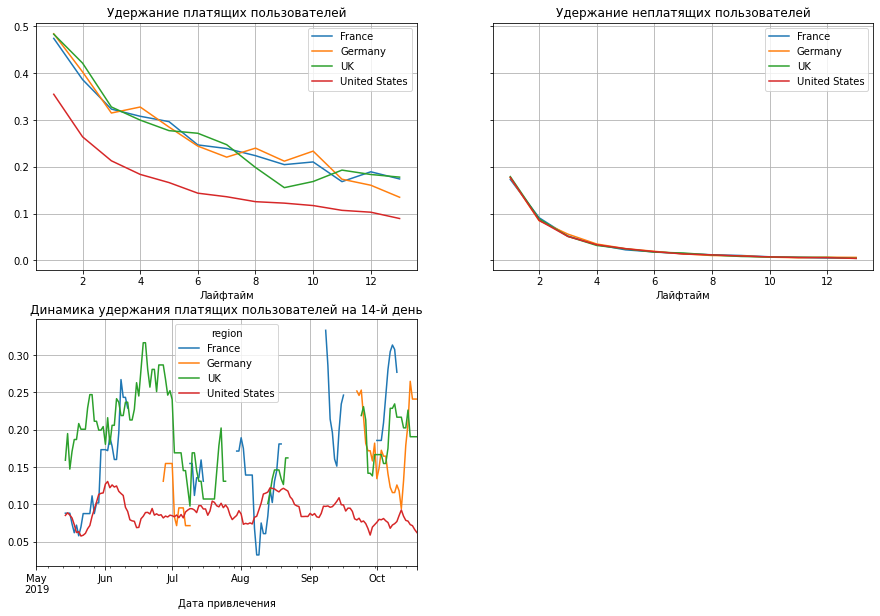

In [36]:
def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
plot_retention(retention_grouped, retention_history, horizon_days)

Ух ты! Неплатящие пользователи ведут себя схоже во всех регионах :) А вот удержание пользователей США к концу второй недели сильно отстает, от Европейских, а ведь ценность одного пользователя из США выше, надо разобраться как их удерживать!
Теоретически может быть связь между САС определнного рекламного канала и низким удержанием пользователей США. Реклама может быть как дорогая, так и плохая, не оправдывать ожиданий например, что ж присмотримся наконец-то к рекламе.

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам
И снова :D

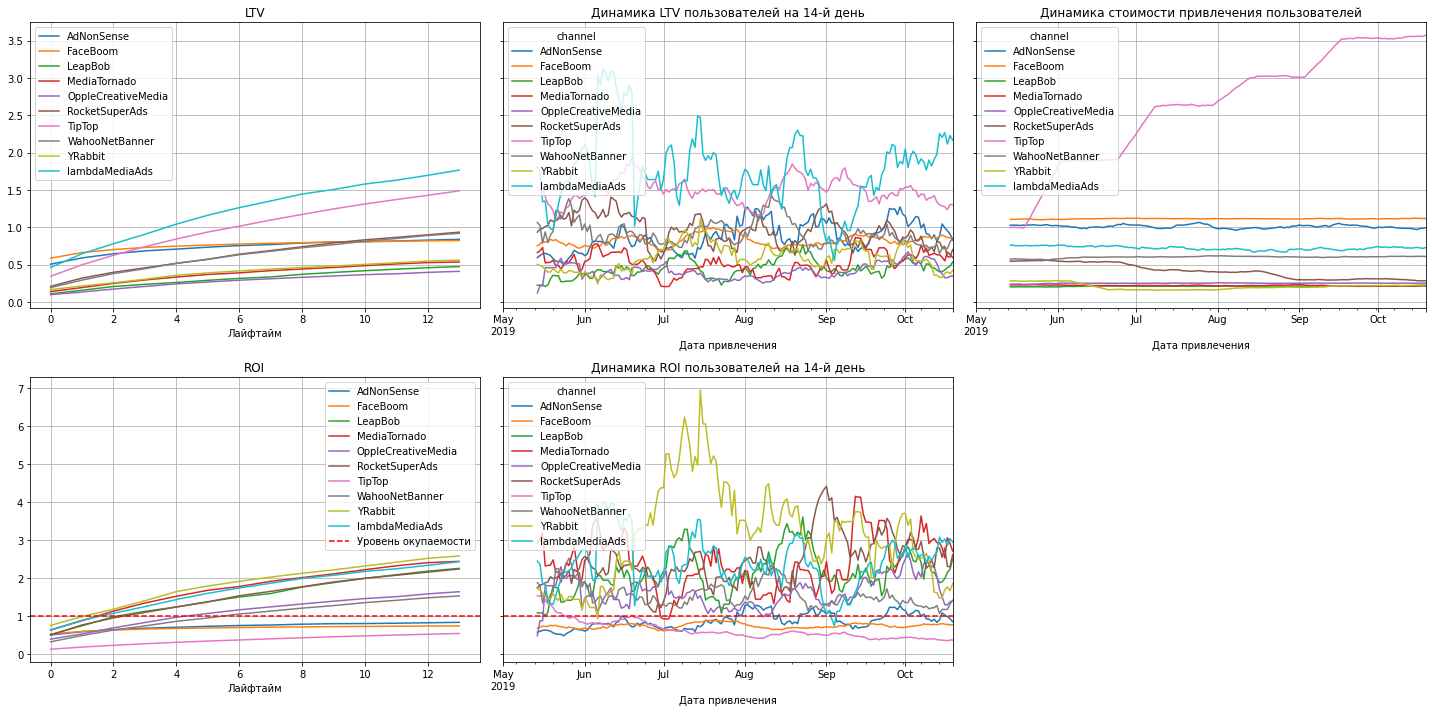

In [37]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders_data, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Вот тут уже совсем интересно. Во первых мне кажется это самые наглядные иллюстрации для отдела маркетинга - сразу видно, какие рекламные каналы себя не оправдывают. То есть например, от каналов AdNonSense, FaceBoom, TipTop я бы отказалась, несмотря на то, что до этого мы видели, что они привлекают сравнительно большое количество пользователей, но реклама на этих каналах себя не окупает даже к концу второй недели - то есть смело можно считать эти рекламные каналы провальными, динамика ROI только подкрепляет мои выводы: реклама в FaceBoom себя не окупила вообще ни розу на протяжении всего рассматриваемого периода, AdNonSense напротив вложения в себя с трудом, но несколько недель оправдывал, но самая подозрительная ситуация с TipTopб который до взмывания стоимости привлечения в целом то себя окупал - думаю тут есть какая то загвоздка.  
Можно выделить успешные рекламные каналы, но по моему все очевидно из графиков, напомню о них в финальном выводе, а сейчас хотелось бы приглядеться к конверсии и удержанию каналов аутсайдеров + оставим какого нибудь крепенького среднячка (не хочется делать графики со всеми каналами, потому что все же получается грязновато):

In [38]:
profiles_temp = profiles
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_temp, orders_data, observation_date, horizon_days, dimensions=dimensions
)
display(conversion_grouped)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
AdNonSense,3702,0.086980,0.094003,0.096704,0.100486,0.102107,0.103998,0.105348,0.105348,0.105889,0.106159,0.106159,0.106969,0.107509,0.107509
FaceBoom,27544,0.102091,0.109134,0.111494,0.113346,0.114762,0.115452,0.116468,0.116976,0.117557,0.118175,0.118465,0.118864,0.119082,0.119373
LeapBob,8103,0.016660,0.020610,0.024065,0.025052,0.026040,0.026657,0.026904,0.027644,0.028261,0.028631,0.028878,0.029002,0.029125,0.029248
MediaTornado,4167,0.023278,0.027358,0.028078,0.029998,0.030478,0.031198,0.031198,0.032397,0.032637,0.032637,0.033357,0.033357,0.033357,0.033357
OppleCreativeMedia,8139,0.017324,0.019904,0.021501,0.023099,0.023713,0.024573,0.025310,0.025556,0.025556,0.025802,0.025925,0.026047,0.026047,0.026293
RocketSuperAds,4251,0.034110,0.047283,0.053870,0.059280,0.063750,0.065632,0.067278,0.068690,0.069866,0.071513,0.072924,0.073159,0.073394,0.073630
TipTop,18498,0.056709,0.069413,0.076062,0.080711,0.084171,0.086604,0.087685,0.089361,0.090550,0.091577,0.092334,0.092767,0.093199,0.093740
WahooNetBanner,8082,0.031180,0.038481,0.043306,0.045038,0.046894,0.048008,0.048874,0.049740,0.050359,0.051101,0.051472,0.051596,0.051720,0.052091
YRabbit,4102,0.025841,0.028766,0.031204,0.032179,0.033398,0.034130,0.034861,0.035349,0.035836,0.036324,0.036324,0.036568,0.036811,0.037055


Канал YRabbit, который окупается и демонстрирует лучший итоговый результат для бизнеса, показывает меньшую конверсию, чем каналы аутсайдеры. Посмотрим тогда, что происходит с удержанием:

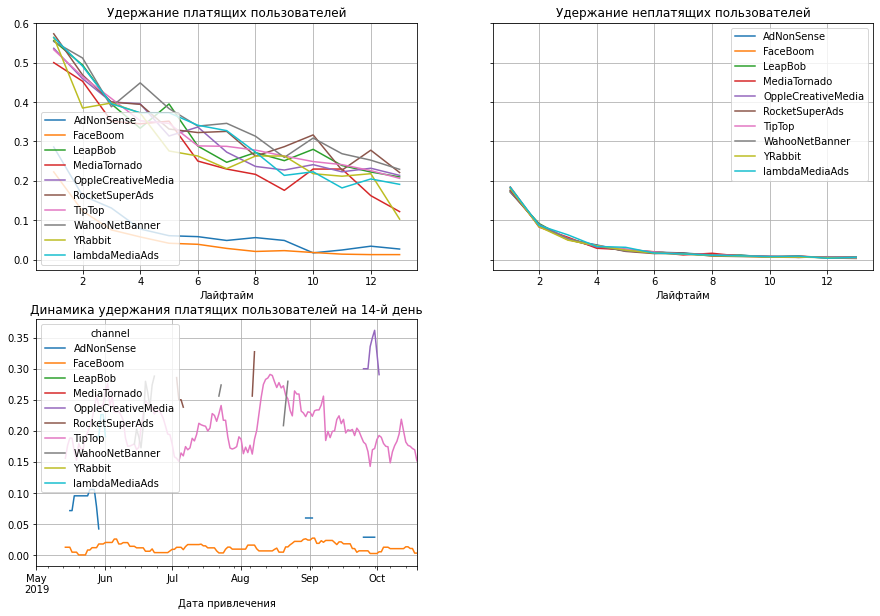

In [39]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_temp, visits_data, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)


На этои этапе 100% можно отказаться от рекламы FaceBoom и AdNonSense, а вот TipTop показывает неплохие результаты: возможно ли такое, что огромный САС и увеличение рекламного бюджета вызвано ошибкой? проверим:

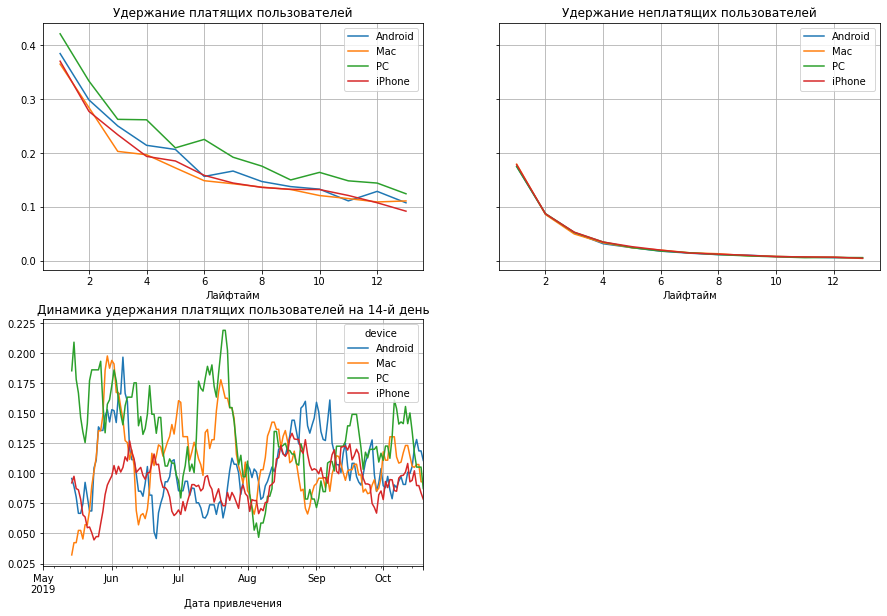

In [40]:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_temp, visits_data, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)


dt
2019-05-01     80.0
2019-05-02     55.0
2019-05-03     64.0
2019-05-04     70.0
2019-05-05     78.0
              ...  
2019-10-23    322.0
2019-10-24    402.5
2019-10-25    483.0
2019-10-26    563.5
2019-10-27    588.0
Name: costs, Length: 180, dtype: float64

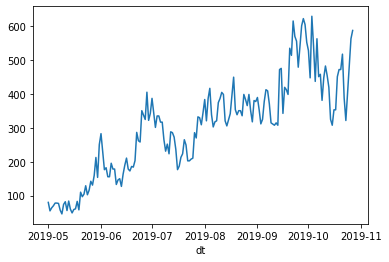

In [41]:
costs_data.query('channel =="TipTop"').groupby('dt')['costs'].median().plot()
display(costs_data.query('channel =="TipTop"').groupby('dt')['costs'].median())

Несмотря на перспективность канала, стоимость выросла на 136%, то есть либо есть ошибка в оплате (ну мало ли в бухгалтерии Пупа и Лупа что-то напутали), либо если ошибки в расчетах за рекламные капмании нет, то придется смириться что мы не можем себе позволить такую рекламу. 

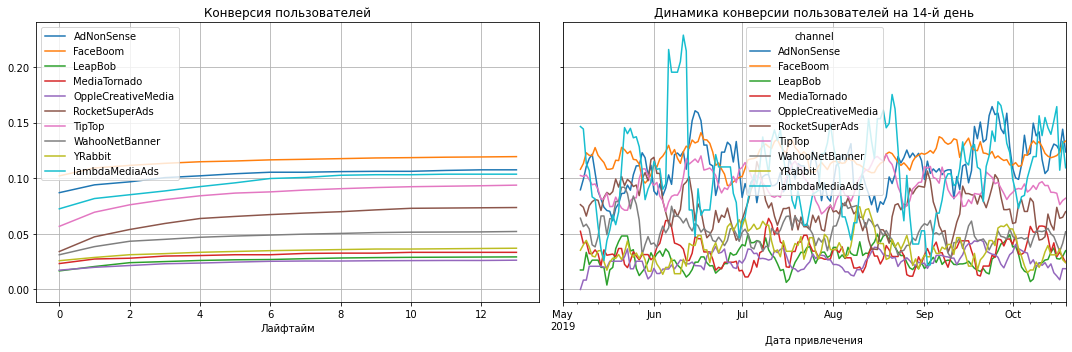

In [42]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()
plot_conversion(conversion_grouped, conversion_history, horizon_days)

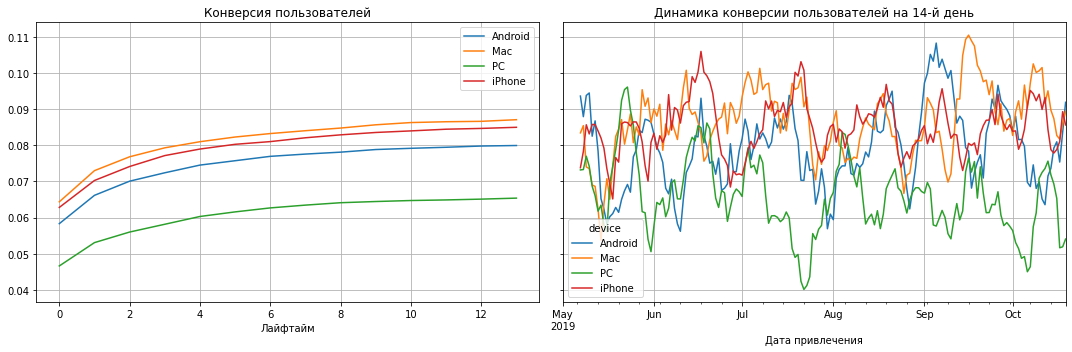

In [43]:
conversion_raw_device, conversion_grouped_device, conversion_history_device = get_conversion(profiles, orders_data, observation_date, horizon_days, dimensions=['device'])
plot_conversion(conversion_grouped_device, conversion_history_device, horizon_days)

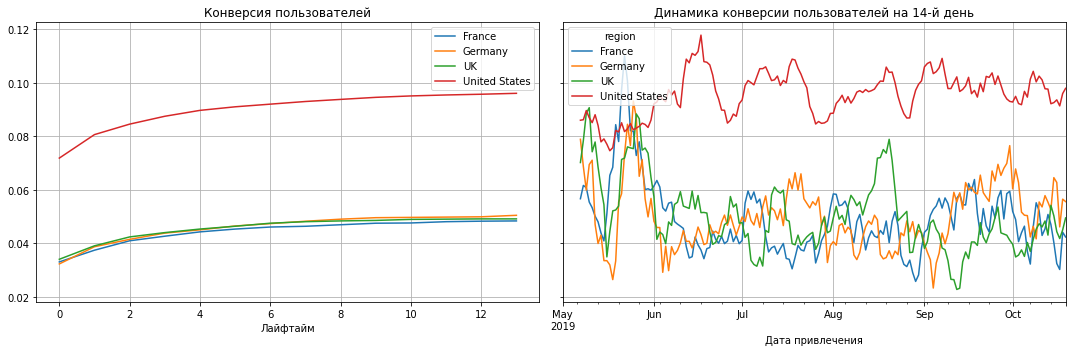

In [44]:
conversion_raw_region, conversion_grouped_region, conversion_history_region = get_conversion(profiles, orders_data, observation_date, horizon_days, dimensions=['region'])
plot_conversion(conversion_grouped_region, conversion_history_region, horizon_days)

## Шаг 6. Напишите выводы
### Выделите причины неэффективности привлечения пользователей
В первую очередь это невроятно выросший бюджет на рекламную компанию по каналу TipTop. Во-вторых низкое удержание пользователей из США, которые составляют большую долю пользователей приложения.
### Сформируйте рекомендации для отдела маркетинга для повышения эффективности.
**1.** Проверить нет ли ошибки с оплатой рекламных компаний по каналу привлечения TipTop  
**2.** Если ошибки нет, то отказаться от ряда нерентабельных рекламных компаний, включая TipTop, а также FaceBoom и AdNonSense  
**3.** Проверить содержимое рекламных компаний, возможно для пользователей из США ожидания не сооттветсвуют реальности или реклама общает то, чего нет, что выливается в низкое удержание пользователей из США.  


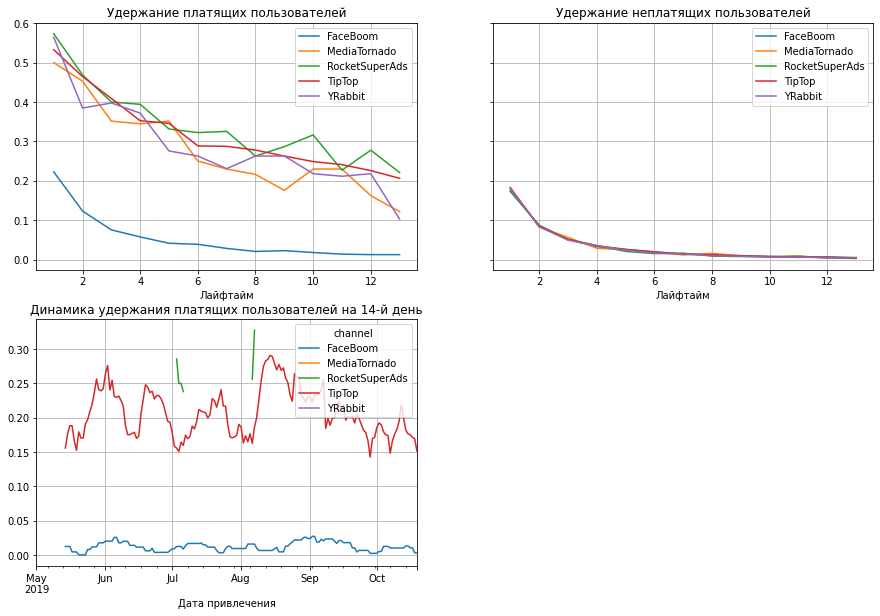

In [45]:
profiles_temp = profiles.query('region == "United States"')
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_temp, visits_data, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)


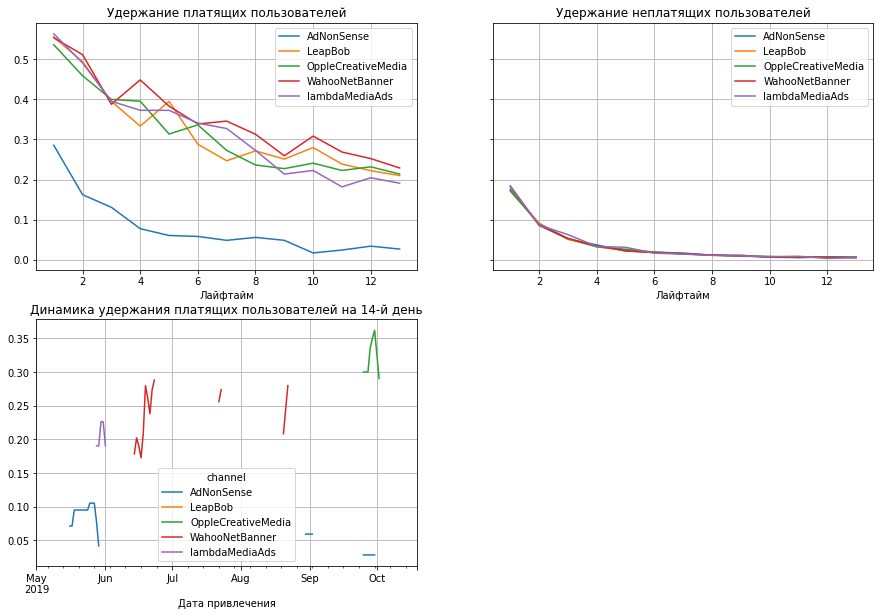

In [46]:
profiles_temp2 = profiles.query('region in ["UK","Germany","France"]')
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_temp2, visits_data, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)
